In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Load IPUMS data
chunks = pd.read_csv("data/usa_00002.csv.gz", chunksize=100_000, low_memory=False)

# Combine all chunks into one DataFrame (or process them one by one)
df = pd.concat(chunks, ignore_index=True)


In [8]:
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,MARST,FERTYR,CLASSWKR,CLASSWKRD,OCC,OCC2010,IND,UHRSWORK,VETSTAT,VETSTATD
0,2013,2009,201305,1,2009000000017,1.0,2013000000015,1,110001,3,...,3,0,0,0,0,9920,0,0,2,20
1,2013,2009,201305,2,2009000000125,5.0,2013000000025,1,260001,1,...,1,0,2,22,5310,5310,8190,40,1,11
2,2013,2009,201305,2,2009000000125,5.0,2013000000025,1,260001,1,...,1,0,2,22,6200,6200,8190,40,2,20
3,2013,2009,201305,3,2009000000181,7.0,2013000000035,1,170001,1,...,4,0,2,22,4020,4000,8270,32,1,11
4,2013,2009,201305,3,2009000000181,7.0,2013000000035,1,170001,1,...,6,0,2,22,5350,5350,5280,40,1,11


In [9]:
print(df.columns.tolist())

['YEAR', 'MULTYEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'STATEFIP', 'STRATA', 'GQ', 'PERNUM', 'PERWT', 'NCHILD', 'RELATE', 'RELATED', 'SEX', 'AGE', 'BIRTHQTR', 'MARST', 'FERTYR', 'CLASSWKR', 'CLASSWKRD', 'OCC', 'OCC2010', 'IND', 'UHRSWORK', 'VETSTAT', 'VETSTATD']


In [ ]:
father_cols = ['SEX', 'AGE', 'MARST', 'NCHILD', 'PERWT', 'CLASSWKR', 'CLASSWKRD', 'OCC', 'IND', 'OCC2010', 'UHRSWORK', 'VETSTAT', 'VETSTATD']
occupation_df = df[father_cols]

qtr_cols = ['SEX', 'AGE', 'MARST', 'BIRTHQTR', 'NCHILD', 'PERWT']
qtr_df = df[qtr_cols]

state_cols = ['SEX', 'AGE', 'MARST', 'NCHILD', 'RELATE', 'RELATED', 'STATEFIP', 'PERWT']
state_df = df[state_cols]

In [27]:
#Father occupational status
fathers = occupation_df[
    (occupation_df['SEX'] == 1) &                     # Male
    (occupation_df['AGE'].between(30, 45)) &          # Filter by age window
    (occupation_df['CLASSWKR'].isin(range(1, 9)))     # Has a real job class
].copy()

fathers_filtered = fathers[
    (fathers['AGE'] >= 30) &
    (fathers['AGE'] <= 45)
].copy()

agg_unweighted = fathers_filtered.groupby("OCC").agg(
    avg_children=("NCHILD", "mean"),
    count=("NCHILD", "count")
).reset_index()

agg_weighted = fathers_filtered.groupby("OCC").apply(
    lambda g: pd.Series({
        "avg_children": (g["NCHILD"] * g["PERWT"]).sum() / g["PERWT"].sum(),
        "count": g["PERWT"].sum()
    })
).reset_index()

In [41]:
# Load occupation labels and merge
occ_labels = pd.read_csv("data/lookups/occ_labels_cleaned.csv", dtype={"OCC": int, "Occupation": str})
agg_unweighted = agg_unweighted.merge(occ_labels, how="left", on="OCC")
agg_weighted = agg_weighted.merge(occ_labels, how="left", on="OCC")

In [56]:
final_weighted = agg_weighted[['avg_children', 'Occupation']]
final_unweighted = agg_unweighted[['avg_children', 'Occupation']]
final_weighted.head()


,avg_children,Occupation
0,1.553411,Chief executives and legislators
1,1.311311,General and operations managers
2,0.980731,Advertising and promotions managers
3,1.351957,NaN
4,1.123288,Marketing managers


In [57]:
top_n = 25
uw_top = final_unweighted.sort_values("avg_children", ascending=False).head(top_n)
uw_top = uw_top.dropna(subset=["Occupation"])
w_top = final_weighted.sort_values("avg_children", ascending=False).head(top_n)
w_top = w_top.dropna(subset=["Occupation"])


In [60]:
w_top.head(20)

,avg_children,Occupation
165,1.976821,Clergy
166,1.792460,"Directors, religious activities and education"
20,1.778063,"Farmers, ranchers, and other agricultural mana..."
456,1.737568,"First-line supervisors of farming, fishing, an..."
240,1.731808,Podiatrists
303,1.695702,First-line supervisors of firefighting and pre...
302,1.622780,First-line supervisors of police and detectives
253,1.603620,Nurse anesthetists
238,1.587813,Surgeons
167,1.587642,"Religious workers, all other"


In [72]:
bottom_n = 25
uw_bottom = final_unweighted.sort_values("avg_children", ascending=False).tail(top_n)
uw_bottom = uw_bottom.dropna(subset=["Occupation"])
w_bottom = final_weighted.sort_values("avg_children", ascending=False).tail(top_n)
w_bottom = w_bottom.dropna(subset=["Occupation"])


In [75]:
w_bottom.tail(25)

,avg_children,Occupation
398,0.621273,"Switchboard operators, including answering ser..."
393,0.605409,Telemarketers
333,0.604334,Waiters and waitresses
357,0.599792,Other entertainment attendants and related wor...
331,0.581505,Fast food and counter workers
336,0.572626,Dishwashers
416,0.564900,"Hotel, motel, and resort desk clerks"
408,0.564785,Tellers
295,0.554586,Medical transcriptionists
188,0.547987,Library technicians


In [76]:
def plot_horizontal_bar(data, title):
    plt.figure(figsize=(10, 8))
    plt.barh(data['Occupation'], data['avg_children'], color='skyblue')
    plt.xlabel("Average Number of Children")
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest bar on top
    plt.tight_layout()
    plt.show()

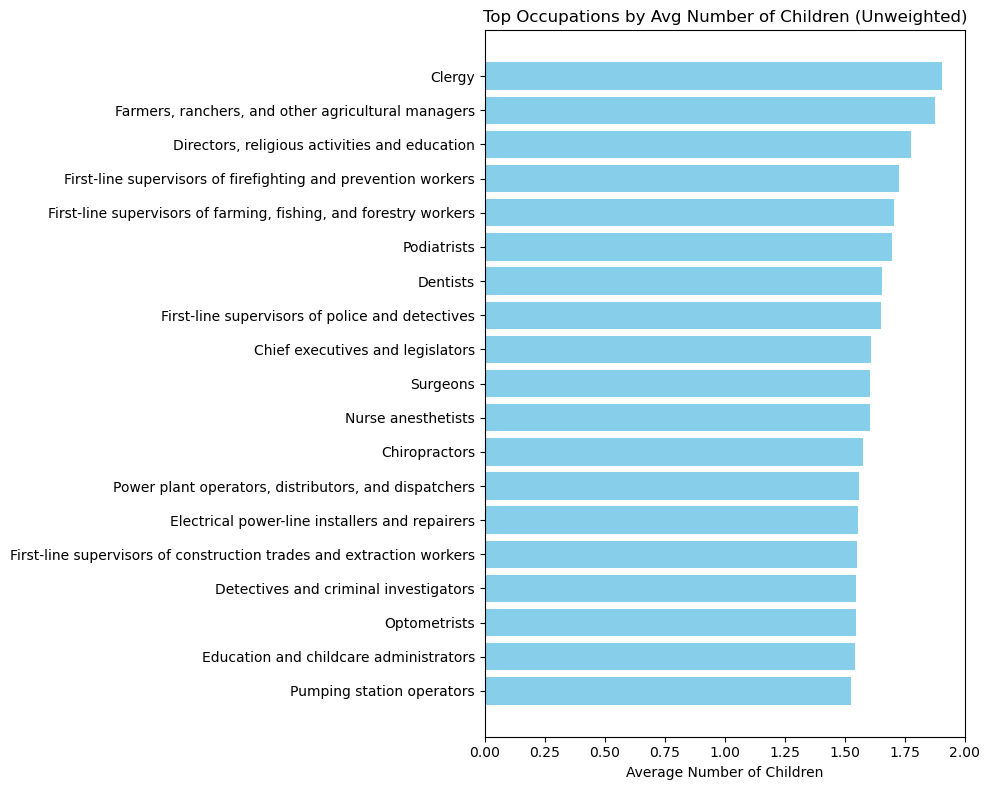

In [77]:
plot_horizontal_bar(uw_top, "Top Occupations by Avg Number of Children (Unweighted)")

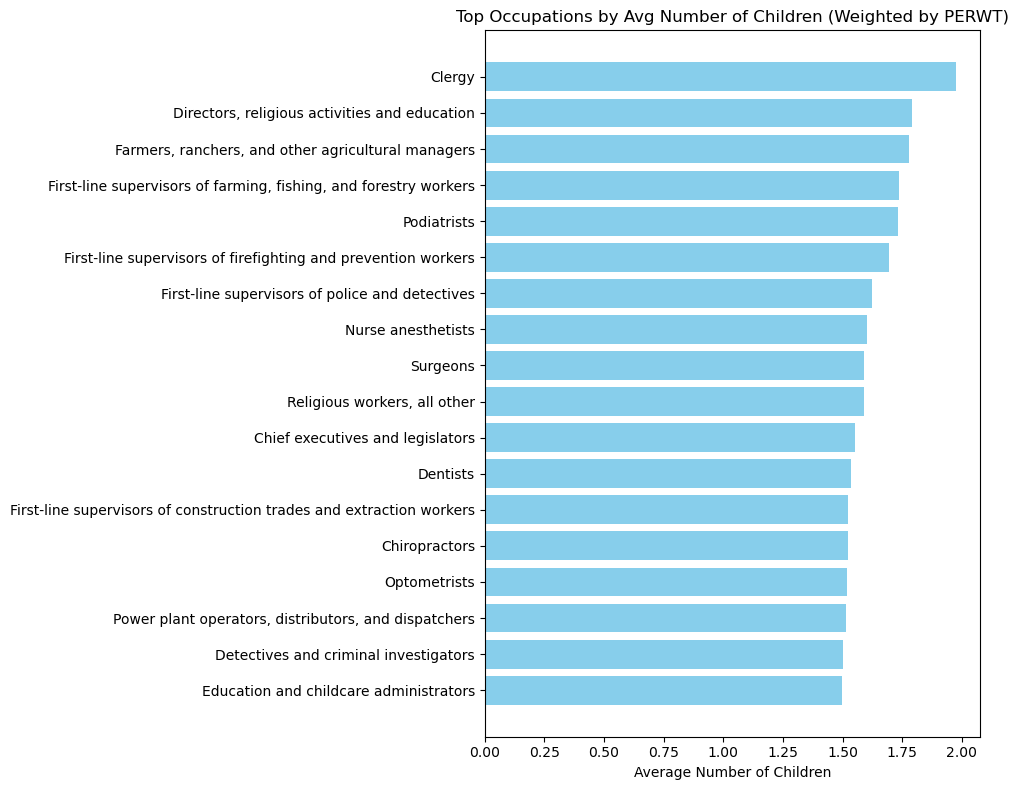

In [78]:
plot_horizontal_bar(w_top, "Top Occupations by Avg Number of Children (Weighted by PERWT)")

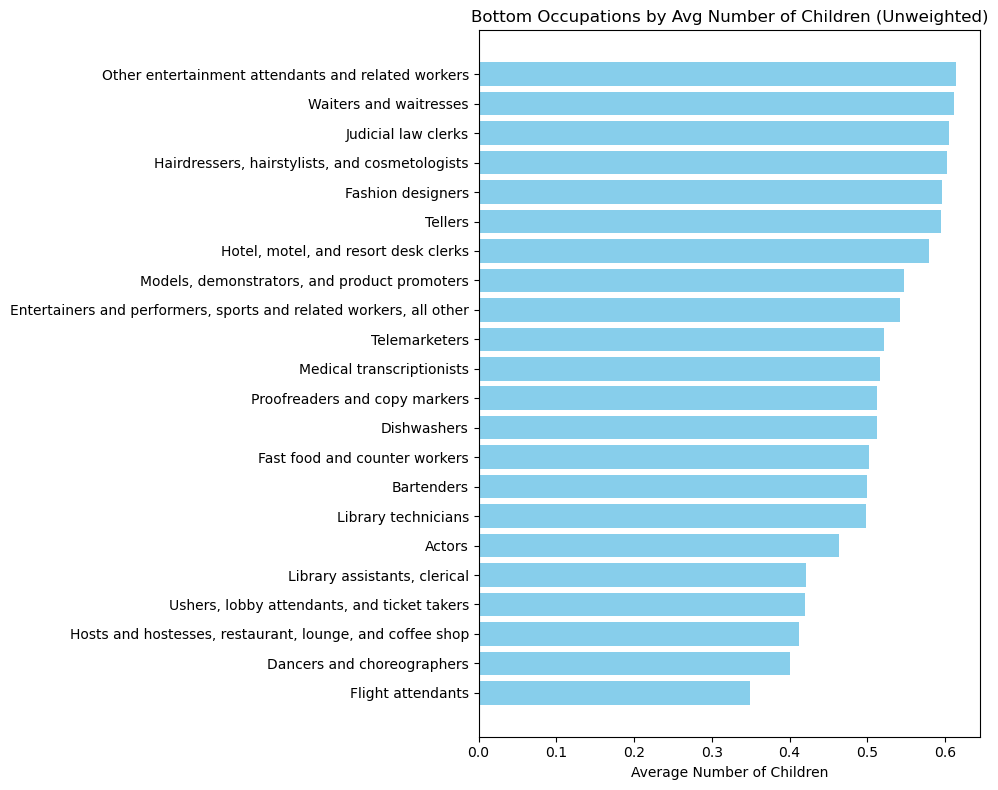

In [79]:
plot_horizontal_bar(uw_bottom, "Bottom Occupations by Avg Number of Children (Unweighted)")

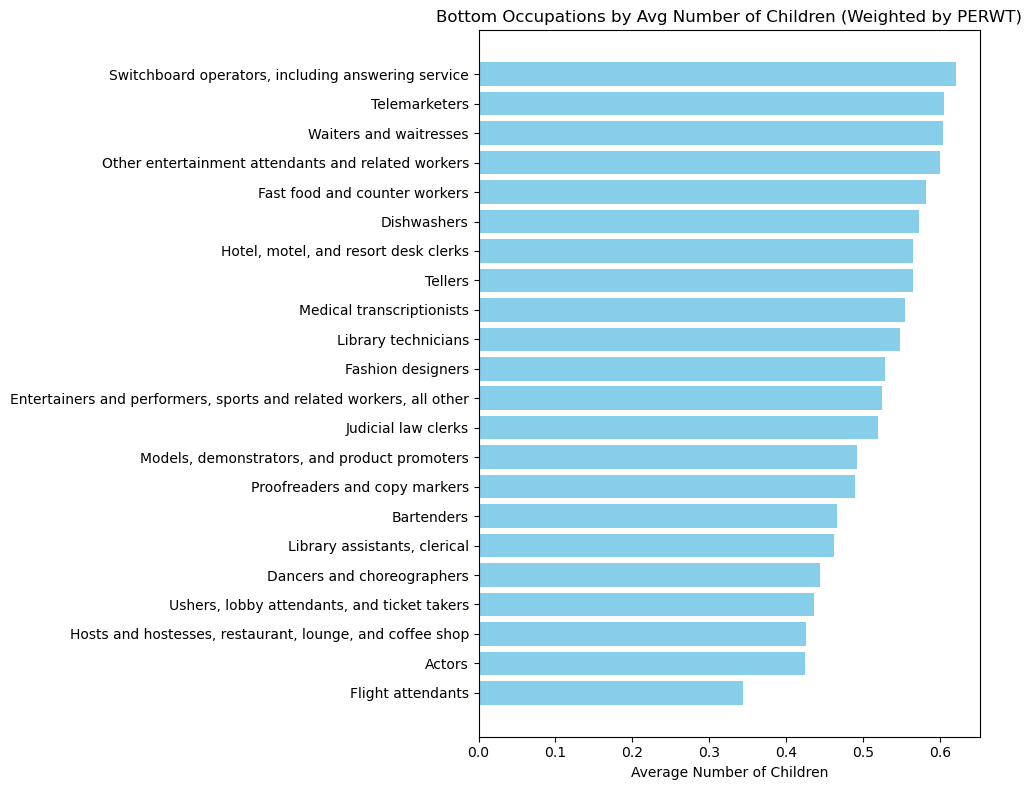

In [80]:
plot_horizontal_bar(w_bottom, "Bottom Occupations by Avg Number of Children (Weighted by PERWT)")

In [ ]:
#Dictionaries
work_class_dict = {
    0:'N/A',
    1:'Self-employed',
    2:'Works for ages',
    9:'Unknown'
}

work_class_dtl_dict = {
    00:'N/A',
    10:'Self-employed',
    11:'Employer',
    12:'Working on own account',
    13:'Self-employed, not incoroprated',
    14:'Self-employed, incoroprated',
    20:'Works for wages or salary',
    21:'Works on salary (1920)',
    22:'Wage/salary, private',
    23:'Wage/salary at non-profit',
    24:'Wage/salary, government',
    25:'Federal government employee',
    26:'Armed forces',
    27:'State government employee (in PR, Commonwealth)',
    28:'Local government employee',
    29:'Unpaid family worker',
    98:'Illegible',
    99:'Unknown'
}




In [23]:
fathers.head()

,SEX,AGE,MARST,NCHILD,PERWT,RELATED,RELATE,CLASSWKR,CLASSWKRD,OCC,IND,OCC2010,UHRSWORK,VETSTAT,VETSTATD
4,1,38,6,0,9.0,301,3,2,22,5350,5280,5350,40,1,11
9,1,42,1,1,21.0,201,2,2,22,6260,770,6260,60,1,11
12,1,35,4,0,8.0,101,1,2,28,3740,9470,3740,40,1,11
14,1,39,1,3,24.0,101,1,2,22,5610,3490,5610,40,1,11
25,1,39,4,0,34.0,101,1,1,14,4460,9080,4460,30,1,11
